# Selecting the Most Efficient Method for a Biological Optimization Problem using Deep Bidirectional Encoder Representations from Transformers (BERT)
Designed to automatically select between deterministic and heuristic methods of solving a biological optimization problem, CutFree, using the BERT unsupervised model architecture.

## Import Dependencies

In [1]:
# system
import os
import csv

# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.metrics import classification_report, confusion_matrix, \
    ConfusionMatrixDisplay

# deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, TFDistilBertModel, \
    AdamWeightDecay
from numba import cuda

# check device
device = cuda.get_current_device()
device.reset()

In [2]:
# clear gpu memory
device.reset()

In [3]:
# check gpu
!nvidia-smi

Fri Sep  8 07:08:07 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2070 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P0              37W / 215W |    804MiB /  8192MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Create Directory Path to Save Model Information

In [4]:
# get previous model version
highest_model_number = 0
for directory in os.listdir("models"):
    model_number = int(directory.split("-V")[-1])
    if model_number >= highest_model_number:
        highest_model_number = model_number + 1

# create save directory
save_folder = "models/AlgorithmClassifier-V" + str(highest_model_number)
os.mkdir(save_folder)

# create other subdirectories
os.mkdir(save_folder + "/checkpoints")
os.mkdir(save_folder + "/logs")
os.mkdir(save_folder + "/plots")
os.mkdir(save_folder + "/results")
os.mkdir(save_folder + "/class_weights")

save_folder

'models/AlgorithmClassifier-V3'

## Clean Dataset to Include Target

In [5]:
# get random state to improve validity of results
random_state = 778 # np.random.randint(0, 1000)

print("Random State: ", random_state)

Random State:  778


In [6]:
# read in data to dataframe
file_path = "../runtime-simulations/runtime_data.csv"
df_original = pd.read_csv(file_path)
df = df_original.copy()

# drop duplicate rows
duplicate_rows = df.duplicated(subset=["Oligo", "Sites"], keep="first")
df = df[~duplicate_rows]

# fix the sites column
df["Sites"] = [s[5:-2] for s in df["Sites"]]
df["Sites"] = [s.replace("\"", "").replace(" ", "") for s in df["Sites"]]
df["Sites"] = [s.split(",") for s in df["Sites"]]

# add time discrepancy column
df["Time_Discrepancy"] = df["CutFree_Time"] - df["CutFreeRL_Time"]

# add correct algorithm column
conditions = [
    (df["CutFree_Time"] <= df["CutFreeRL_Time"]),
    (df["CutFree_Time"] > df["CutFreeRL_Time"])
]
values = [0, 1] # 0 = CutFree, 1 = CutFreeRL
df["Correct_Algorithm_Choice"] = np.select(conditions, values)

# adjust correct algorithm based on degeneracy if it outside of the confidence 
# interval (i.e., ignore cutfreerl if the degeneracy loss is too significant, 
# typically caused by incomplete cutfreerl output)
df.loc[df["CutFree_Degeneracy"] == 0, "Correct_Algorithm_Choice"] = 1
df.loc[
    df["CutFreeRL_Degeneracy"] <= df["CutFree_Degeneracy"]
    - (df["CutFree_Degeneracy"] * 0.10),
    "Correct_Algorithm_Choice"
] = 0

# count classifcations
class_counts = df["Correct_Algorithm_Choice"].value_counts()
print(class_counts)

# shuffle dataframe
df = df.sample(
    frac=1, 
    random_state=random_state
).reset_index(drop=True).drop(columns=["Unnamed: 0"])

df.head()

Correct_Algorithm_Choice
0    20680
1     6654
Name: count, dtype: int64


,Oligo,Oligo_Length,Sites,Number_of_Sites,Site_Length,CutFree_Randomer,CutFree_Degeneracy,CutFree_Time,CutFreeRL_Randomer,CutFreeRL_Degeneracy,CutFreeRL_Time,Time_Discrepancy,Correct_Algorithm_Choice
0,NNNNNNNN,8,"[CCTNAGG, ACCWGGT, GCTNAGC]",3,7,NDDNNNNN,10.514991,0.007215,NNNNNHHN,10.514991,0.240771,-0.233556,0
1,NNNNNNNNNN,10,[CCNGG],1,5,NDNNNNHNHN,12.999897,0.006216,NNNNHNHNHN,12.999897,0.218797,-0.212580,0
2,NNNNNNNNNNNNNNNNNNNNNNNN,24,"[TTSAA, GCAGC, CCSGG]",3,5,NVNNWNDKNSBNWNDBVBDWNNBN,27.216190,0.285090,NNNNTNDBNBDTNNBNTNDBNBWB,25.829896,0.741017,-0.455928,0
3,NNNNNN,6,[RTGCGCAY],1,8,NNNNNN,8.317766,0.003960,NNNNNN,8.317766,0.091330,-0.087370,0
4,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,33,"[AATT, CTAG, RGCY]",3,4,DNVRNRNRNRNRNRNRNRNRNRNRNRNRNRNRN,34.775142,0.098563,NNNAHVNRHRNRNRNRNRNRNRNRNRNRNRNRN,34.487460,0.739652,-0.641089,0


## Get Train, Validation, and Test Data

In [7]:
# gather text and label information for tokenization by concatenating a padded
# version of the restriction sites together and adding the oligo length, number
# of sites, and site length to the end of the string for future reference
texts = []
labels = []
for index, row in df.iterrows():
    temp_text = []
    for site in row["Sites"]:
        site = site + " "
        temp_text.append(site)
        
    oligo_length = row["Oligo_Length"]
    if oligo_length < 10:
        oligo_length = "0" + str(oligo_length)
    temp_text.append(str(oligo_length))

    number_of_sites = row["Number_of_Sites"]
    if number_of_sites < 10:
        number_of_sites = "0" + str(number_of_sites)
    temp_text.append(str(number_of_sites))

    site_length = row["Site_Length"]
    if site_length < 10:
        site_length = "0" + str(site_length)
    temp_text.append(str(site_length))

    texts.append("".join(temp_text))
    labels.append(row["Correct_Algorithm_Choice"])

texts[0], labels[0]

('CCTNAGG ACCWGGT GCTNAGC 080307', 0)

In [8]:
# create train, validation, and test data for text and lebels
x_train, x_test, y_train, y_test = train_test_split(
    texts, 
    labels, 
    test_size=0.2, 
    random_state=random_state
)

print("Train and Test Sizes: ", len(x_train), len(x_test))

Train and Test Sizes:  21867 5467


In [9]:
# extract oligo length, number of sites, and site length from each text
# for the train, validation, and test data
x_train_oligo_lengths = []
x_train_number_of_sites = []
x_train_site_lengths = []
for x in x_train:
    x_train_oligo_lengths.append(int(x[-6:-4]))
    x_train_number_of_sites.append(int(x[-4:-2]))
    x_train_site_lengths.append(int(x[-2:]))

x_test_oligo_lengths = []
x_test_number_of_sites = []
x_test_site_lengths = []
for x in x_test:
    x_test_oligo_lengths.append(int(x[-6:-4]))
    x_test_number_of_sites.append(int(x[-4:-2]))
    x_test_site_lengths.append(int(x[-2:]))

In [10]:
# drop last 6 characters from each text to remove the oligo length, number of
# sites, site length, and last space and leave only the restriction sites
x_train = [x[:-7] for x in x_train]
x_test = [x[:-7] for x in x_test]

x_train[:3], y_train[:3]

(['GGCC TTAA CCTC', 'CTCAG', 'CCDG AGCT AATT'], [0, 0, 0])

## Set Constants

In [11]:
# constants
KFOLDS = 5
MAX_LENGTH = 128
EPOCHS = 30
MLP_EPOCHS = 15
BATCH_SIZE = 32
BERT_MODEL_NAME = "distilbert-base-uncased"

## Create, Compile, Train, and Save Model

In [12]:
def build_bert():
    # bert input layers
    input_ids = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), 
        name="input_ids", 
        dtype="int32"
    )
    attention_mask = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), 
        name="attention_mask", 
        dtype="int32"
    )

    # bert model
    bert_model = TFDistilBertModel.from_pretrained(
        BERT_MODEL_NAME, 
        output_attentions=False, 
        output_hidden_states=False
    )([input_ids, attention_mask])
    bert_output = bert_model.last_hidden_state[:, 0, :]
    bert_head = tf.keras.layers.Dropout(
        0.8, 
        name="dropout_0_bert"
    )(bert_output)

    # oligo length input layer
    oligo_length_input = tf.keras.layers.Input(
        shape=(1,),
        name="oligo_length_input",
        dtype="float32"
    )

    # concatenate bert and oligo outputs
    concatenate = tf.keras.layers.concatenate(
        [bert_head, oligo_length_input], 
        name="concatenate"
    )

    # mlp for head of bert model
    bert_mlp = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                768, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_1_bert"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_1_bert"),
            tf.keras.layers.Dropout(0.4, name="dropout_1_bert"),
            tf.keras.layers.Activation("relu", name="relu_1_bert"),
            tf.keras.layers.Dense(
                128, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_2_bert"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_2_bert"),
            tf.keras.layers.Dropout(0.4, name="dropout_2_bert"),
            tf.keras.layers.Activation("relu", name="relu_2_bert"),
            tf.keras.layers.Dense(
                64, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_3_bert"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_3_bert"),
            tf.keras.layers.Dropout(0.4, name="dropout_3_bert"),
            tf.keras.layers.Activation("relu", name="relu_3_bert")
        ], 
        name="bert_mlp"
    )(concatenate)

    # output layer
    output = tf.keras.layers.Dense(
        2, 
        activation="softmax", 
        name="output"
    )(bert_mlp)

    # combine input and output layers to create model
    model = tf.keras.Model(
        inputs=[input_ids, attention_mask, oligo_length_input], 
        outputs=output, 
        name="BERT_AlgorithmClassifier"
    )

    return model

model = build_bert()
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "BERT_AlgorithmClassifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 128, 768),                                                   
                                 hidden_states=None                        

In [13]:
# kfold cross validation
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=random_state)    

# convert to arrays
x_train_array = np.array(x_train)
y_train_array = np.array(y_train)

# initialize list to store histories
bert_history = []
bert_models = []

for k, (train_index, val_index) in enumerate(
    kf.split(x_train_array, y_train_array)
):
    # initialize tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)

    # instantiate new model
    model = build_bert()

    # create optimizer and loss function
    optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    # compile model
    model.compile(optimizer, loss, metrics=["accuracy"])

    # get train and validation data
    x_train_cv = x_train_array[train_index]
    x_val_cv = x_train_array[val_index]
    y_train_cv = y_train_array[train_index]
    y_val_cv = y_train_array[val_index]

    # make tensor for train data that contains the oligo length
    bert_train_ints = tf.convert_to_tensor(
        (x_train_oligo_lengths)
    )

    # class weights (if not balanced)
    class_weights = dict(
        enumerate(
            compute_class_weight(
                class_weight="balanced", 
                classes=np.unique(y_train_cv), 
                y=np.array(y_train_cv)
            )
        )
    )

    # save class weights
    with open(
        save_folder + f"/class_weights/k{str(k)}_class_weights.csv", "w"
    ) as f:
        for key in class_weights.keys():
            f.write("%s,%s\n"%(key, class_weights[key]))

    # callbacks for early stopping, saving checkpoints, and tensorboard
    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=3,
            monitor="val_loss"
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=save_folder \
                + "/checkpoints/k" + str(k) + "_best_model_acc.h5",
            monitor="val_accuracy", 
            save_best_only=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=save_folder \
                + "/checkpoints/k" + str(k) + "_best_model_loss.h5",
            monitor="val_loss", 
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=save_folder + "/logs"
        )
    ]
    
    # tokenize training data
    tokens_train = tokenizer.batch_encode_plus(
        x_train_cv, 
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="tf"
    )

    # get input ids and attention masks for training data
    input_ids_train = tokens_train["input_ids"]
    attention_mask_train = tokens_train["attention_mask"]

    # make tensors for training data
    texts_train = (
        input_ids_train, 
        attention_mask_train, 
        np.array(bert_train_ints)[train_index]
    )
    labels_train = tf.constant(y_train_cv)
    bert_train_dataset = tf.data.Dataset.from_tensor_slices(
        (texts_train, labels_train)
    ).shuffle(len(labels_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # tokenize validation data
    tokens_val = tokenizer.batch_encode_plus(
        x_val_cv, 
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="tf"
    )

    # get input ids and attention masks for validation data
    input_ids_val = tokens_val["input_ids"]
    attention_mask_val = tokens_val["attention_mask"]

    # make tensors for validation data
    texts_val = (
        input_ids_val, 
        attention_mask_val, 
        np.array(bert_train_ints)[val_index]
    )
    labels_val = tf.constant(y_val_cv)
    bert_val_dataset = tf.data.Dataset.from_tensor_slices(
        (texts_val, labels_val)
    ).shuffle(len(labels_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    # fine-tune model to training data
    bert_history.append(
        model.fit(
            bert_train_dataset,
            validation_data=bert_val_dataset, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE,
            class_weight=class_weights,
            callbacks=model_callbacks
        )
    )

    # save models
    bert_models.append(model)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [14]:
# load tensorboard
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [15]:
# build an mlp to classify the algorithm based on the oligo length, number of
# sites, and site length as a comparison metric for the bert model
def build_mlp():
    # oligo length, number of sites, and site length
    mlp_inputs = tf.keras.Input(
        shape=(3,),
        name="mlp_inputs",
        dtype="float32"
    )

    # 2 layer mlp
    mlp = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                128, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_1_mlp"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_1_mlp"),
            tf.keras.layers.Dropout(0.4, name="dropout_1_mlp"),
            tf.keras.layers.Activation("relu", name="relu_1_mlp"),
            tf.keras.layers.Dense(
                64, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_2_mlp"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_2_mlp"),
            tf.keras.layers.Dropout(0.4, name="dropout_2_mlp"),
            tf.keras.layers.Activation("relu", name="relu_2_mlp")
        ], 
        name="mlp"
    )(mlp_inputs)

    # softmax output layer
    mlp_outputs = tf.keras.layers.Dense(
        2,
        activation="softmax",
        name="mlp_outputs"
    )(mlp)
    
    # instantiate model
    mlp_model = tf.keras.Model(
        inputs=mlp_inputs,
        outputs=mlp_outputs,
        name="MLP_AlgorithmClassifier"
    )

    return mlp_model

In [16]:
# make tensors for train and validation data that contain the oligo length, 
# number of sites, and site length
x_train_array_mlp = np.array(
    (x_train_oligo_lengths, x_train_number_of_sites, x_train_site_lengths)
).T
y_train_array_mlp = np.array(y_train)

# kfold cross validation
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=random_state) 

history_mlp = []
mlp_models = []
for k, (train_index, val_index) in enumerate(
    kf.split(x_train_array_mlp, y_train_array_mlp)
):
    # instantiate new model
    mlp_model = build_mlp()

    # create optimizer and loss function
    optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    # compile model
    mlp_model.compile(optimizer, loss, metrics=["accuracy"])

    # get train and validation data
    x_train_mlp_cv = x_train_array_mlp[train_index]
    x_val_mlp_cv = x_train_array_mlp[val_index]
    y_train_mlp_cv = tf.constant(y_train_array_mlp[train_index])
    y_val_mlp_cv = tf.constant(y_train_array_mlp[val_index])

    # class weights (if not balanced)
    class_weights = dict(
        enumerate(
            compute_class_weight(
                class_weight="balanced", 
                classes=np.unique(y_train_mlp_cv), 
                y=np.array(y_train_mlp_cv)
            )
        )
    )

    # callbacks for early stopping, saving checkpoints, and tensorboard
    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3)
    ]

    # make tensors for training and validation datasets
    mlp_train_dataset = tf.data.Dataset.from_tensor_slices(
        (x_train_mlp_cv, y_train_mlp_cv)
    ).shuffle(len(train_index)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    mlp_val_dataset = tf.data.Dataset.from_tensor_slices(
        (x_val_mlp_cv, y_val_mlp_cv)
    ).shuffle(len(val_index)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # fit model to training data
    history_mlp.append(
        mlp_model.fit(
            mlp_train_dataset,
            validation_data=mlp_val_dataset, 
            epochs=MLP_EPOCHS, 
            batch_size=BATCH_SIZE,
            class_weight=class_weights,
            callbacks=model_callbacks
        )
    )

    # save new model
    mlp_models.append(mlp_model)

Epoch 1/15
547/547 [==============================] - 5s 7ms/step - loss: 1.8262 - accuracy: 0.5685 - val_loss: 1.6442 - val_accuracy: 0.7021
Epoch 2/15
547/547 [==============================] - 4s 7ms/step - loss: 1.6171 - accuracy: 0.6816 - val_loss: 1.4782 - val_accuracy: 0.7421
Epoch 3/15
547/547 [==============================] - 4s 6ms/step - loss: 1.5058 - accuracy: 0.7111 - val_loss: 1.3745 - val_accuracy: 0.7567
Epoch 4/15
547/547 [==============================] - 4s 6ms/step - loss: 1.4134 - accuracy: 0.7270 - val_loss: 1.2912 - val_accuracy: 0.7599
Epoch 5/15
547/547 [==============================] - 4s 6ms/step - loss: 1.3409 - accuracy: 0.7333 - val_loss: 1.2185 - val_accuracy: 0.7647
Epoch 6/15
547/547 [==============================] - 4s 6ms/step - loss: 1.2747 - accuracy: 0.7358 - val_loss: 1.1671 - val_accuracy: 0.7647
Epoch 7/15
547/547 [==============================] - 4s 6ms/step - loss: 1.2156 - accuracy: 0.7395 - val_loss: 1.1219 - val_accuracy: 0.7652
Epoch 

## Evaluate BERT Model Performance

In [17]:
k = 0
for hist in bert_history:
    fig = plt.figure(figsize=(16, 12))

    # create accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # create loss plot
    plt.subplot(2, 1, 2)
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

    # save figure
    fig.savefig(save_folder + "/plots/k" + str(k) + "_training.png")

    # update count
    k += 1

In [35]:
# make tensor for test data that contains the oligo length
bert_test_ints = tf.convert_to_tensor(
    (x_test_oligo_lengths)
)

# tokenize test data
tokens_test = tokenizer.batch_encode_plus(
    x_test, 
    padding="max_length",
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

# get input ids and attention masks for test data
input_ids_test = tokens_test["input_ids"]
attention_mask_test = tokens_test["attention_mask"]

# make tensors for bert test data
texts_test = (
    input_ids_test, 
    attention_mask_test, 
    bert_test_ints
)
labels_test = tf.constant(y_test)
bert_test_dataset = tf.data.Dataset.from_tensor_slices(
    (texts_test, labels_test)
).shuffle(len(labels_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# load bert models
bert_models = []
for k in range(3):
    # load model
    model = tf.keras.models.load_model(
        f"./models/AlgorithmClassifier-V1/checkpoints/k{k}_best_model_loss.h5",
        custom_objects={
            "TFDistilBertModel": TFDistilBertModel, 
            "AdamWeightDecay": AdamWeightDecay
        }
    )
    
    # save model
    bert_models.append(model)

# get average accuracy of bert-based models
bert_accs = []
for model in bert_models:
    _, acc = model.evaluate(bert_test_dataset)
    bert_accs.append(acc * 100)

171/171 [==============================] - 16s 86ms/step - loss: 0.9315 - accuracy: 0.8985


In [36]:
# make tensors for test labels
labels_test = tf.constant(y_test)

# make tensors for mlp test data
tf_test_mlp = tf.transpose(
    tf.convert_to_tensor(
        (x_test_oligo_lengths, x_test_number_of_sites, x_test_site_lengths)
    )
)
mlp_test_dataset = tf.data.Dataset.from_tensor_slices(
    (tf_test_mlp, labels_test)
).shuffle(len(labels_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# get average accuracy of mlp-based models
mlp_accs = []
for mlp_model in mlp_models:
    _, acc = mlp_model.evaluate(mlp_test_dataset)
    mlp_accs.append(acc * 100)

  1/171 [..............................] - ETA: 4s - loss: 0.9725 - accuracy: 0.6875

171/171 [==============================] - 1s 3ms/step - loss: 0.9111 - accuracy: 0.7399


In [37]:
# get statistics for each model
bert_acc = np.mean(bert_accs)
bert_std = np.std(bert_accs)

mlp_acc = np.mean(mlp_accs)
mlp_std = np.std(mlp_accs)

# save accuracies and standard deviations
with open(save_folder + "/results/accuracies.csv", "w") as f:
    f.write("BERT Model Accuracy: " + str(bert_acc) + "\n")
    f.write("BERT Model Standard Deviation: " + str(bert_std) + "\n")
    f.write("MLP Model Accuracy: " + str(mlp_acc) + "\n")
    f.write("MLP Model Standard Deviation: " + str(mlp_std) + "\n")

# compare performance of bert-based model to mlp-based model
print("BERT Model Accuracy: ", bert_acc, "+/-", bert_std)
print("MLP Model Accuracy: ", mlp_acc, "+/-", mlp_std)

BERT Model Accuracy:  88.93969853719075 +/- 0.6476229134278224
MLP Model Accuracy:  73.173588514328 +/- 0.6066182957152697


In [38]:
# retrieve model predictions on test data
y_pred = model.predict(texts_test)
y_pred = np.argmax(y_pred, axis=1)

# create classification report
class_report = classification_report(
    y_pred, 
    y_test, 
    target_names=["CutFree", "CutFreeRL"]
)

# save classification report
with open(save_folder + "/plots/classification_report.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([class_report])
    
print(class_report)

171/171 [==============================] - 16s 84ms/step
              precision    recall  f1-score   support

     CutFree       0.93      0.93      0.93      4168
   CutFreeRL       0.78      0.79      0.79      1299

    accuracy                           0.90      5467
   macro avg       0.86      0.86      0.86      5467
weighted avg       0.90      0.90      0.90      5467



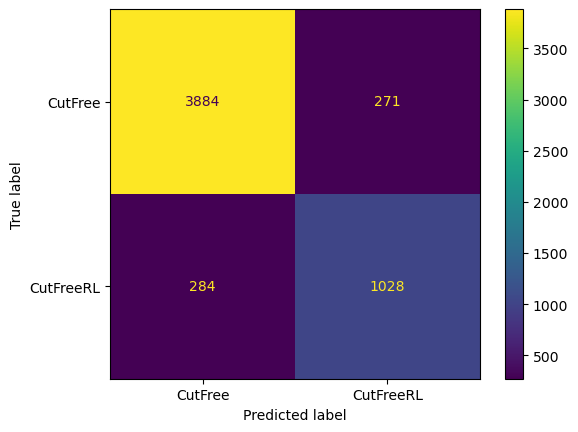

In [39]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm, display_labels=["CutFree", "CutFreeRL"])
fig.plot()

# save confusion matrix
plt.savefig(save_folder + "/plots/confusion_matrix.png")

## Plot Correct Selection for CutFree and CutFreeRL

In [40]:
# sort dataframe by time discrepancy
df = df.sort_values(by=["Time_Discrepancy"]).reset_index(drop=True)

In [41]:
# set colors and font for plots
rgb = []
for _ in df[df["Correct_Algorithm_Choice"] == 0].index:
    c = [46/255, 108/255, 190/255]
    rgb.append(c)

rgb2 = []
for _ in df[df["Correct_Algorithm_Choice"] == 1].index:
    c = [220/255, 77/255, 58/255]
    rgb2.append(c)

gfont = {"fontname": "Georgia"}
font = font_manager.FontProperties(family="Georgia", style="normal", size=32)

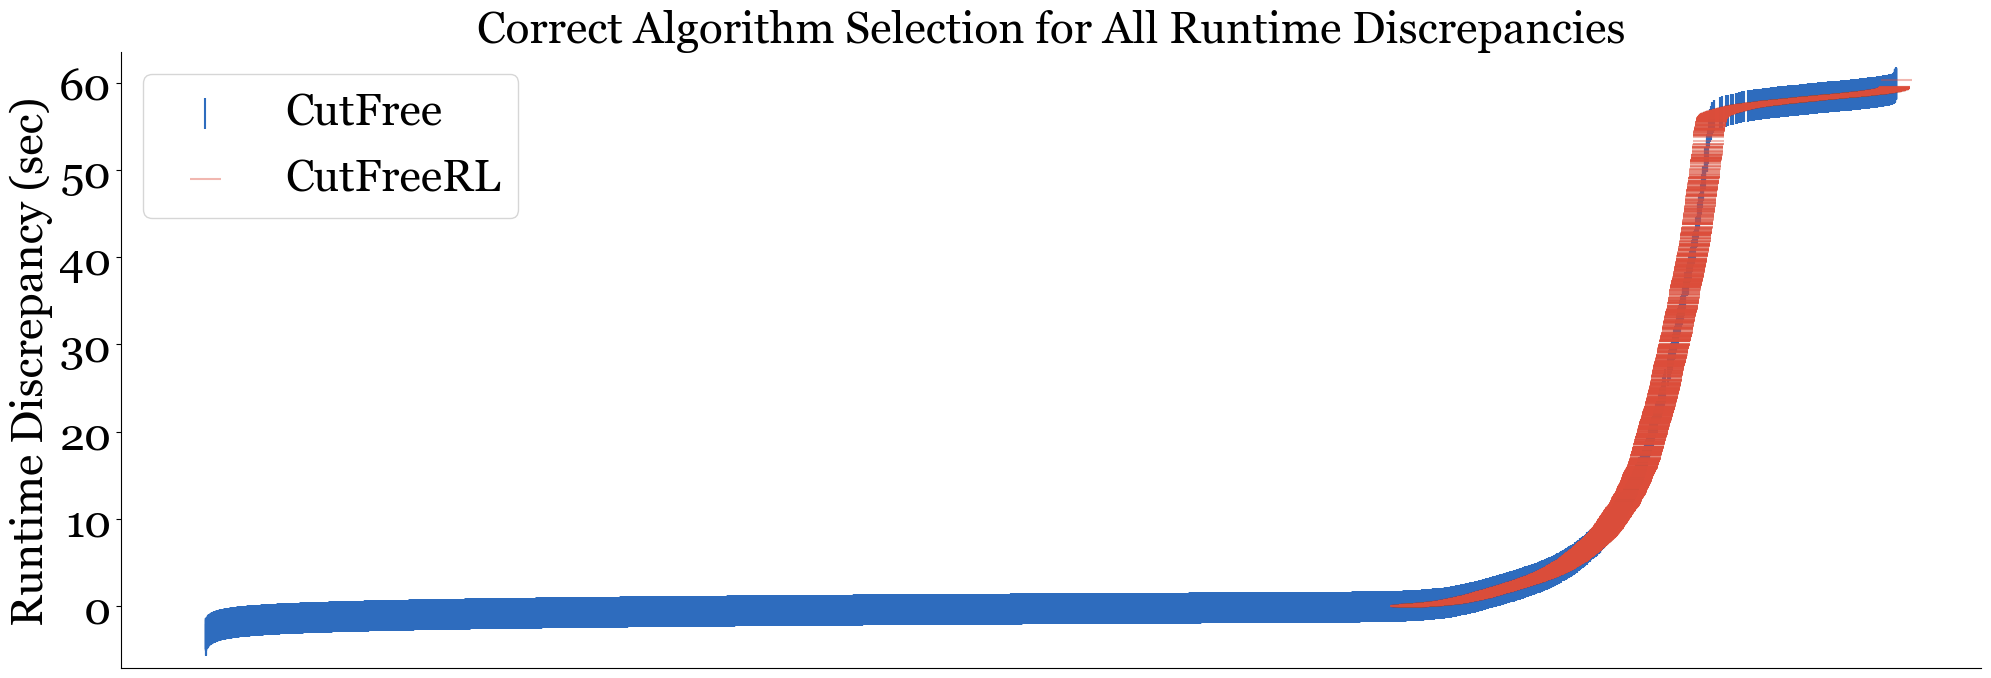

In [42]:
plt.figure(figsize=(24, 8))

# plot expected algorithm selection for all time discrepancies
plt.scatter(
    df[df["Correct_Algorithm_Choice"] == 0].index, 
    df[df["Correct_Algorithm_Choice"] == 0]["Time_Discrepancy"], 
    c=rgb,
    marker="|",
    s=500,
)
plt.scatter(
    df[df["Correct_Algorithm_Choice"] == 1].index, 
    df[df["Correct_Algorithm_Choice"] == 1]["Time_Discrepancy"], 
    c=rgb2,
    marker="_",
    s=500,
    alpha=0.4
)
    
# set labels
plt.title(
    "Correct Algorithm Selection for All Runtime Discrepancies", 
    fontsize=32, 
    **gfont
)
plt.ylabel(
    "Runtime Discrepancy (sec)", 
    fontsize=32, 
    **gfont
)
plt.legend(
    ["CutFree", "CutFreeRL"], 
    prop=font
)

# fix axis
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# save figure
plt.savefig(save_folder + "/plots/correct_algorithm_selection.png")

## Plot Predictions for Selection of CutFree and CutFreeRL

In [43]:
# organize test data for analysis
x_test = np.array(x_test)

# get oligos from test inputs
x_test_oligos = ["N" * x for x in x_test_oligo_lengths]

# get sites from test inputs
x_test_sites = []
for x in x_test:
    temp_sites = [x[i:i+10] for i in range(0, 100, 10)]
    temp_sites = [s.replace(" ", "") for s in temp_sites]
    temp_sites = list(filter(None, temp_sites))
    x_test_sites.append(temp_sites)

print(len(x_test_oligos), len(x_test_sites), len(y_test))

5467 5467 5467


In [44]:
# copy dataframe
df_test = df.copy()

# add prediction column using test data
for oligo, site, pred, test in zip(x_test_oligos, x_test_sites, y_pred, y_test):
    for index, (oligo_df, sites_df) in \
        enumerate(zip(df_test["Oligo"].values, df_test["Sites"].values)):
        if (oligo == oligo_df) and (site == sites_df):
            df_test.loc[index, "Prediction"] = pred == test

# drop unassigned rows
df_test = df_test.dropna(subset=["Prediction"])

# set prediction algorithm
cutfree_condition = \
    ((df_test["Prediction"] == True) \
        & (df_test["Correct_Algorithm_Choice"] == 0)) \
        | ((df_test["Prediction"] == False) \
        & (df_test["Correct_Algorithm_Choice"] == 1))
cutfreerl_condition = \
    ((df_test["Prediction"] == True) \
        & (df_test["Correct_Algorithm_Choice"] == 1)) \
        | ((df_test["Prediction"] == False) \
        & (df_test["Correct_Algorithm_Choice"] == 0))
df_test.loc[cutfree_condition, "Prediction"] = 0
df_test.loc[cutfreerl_condition, "Prediction"] = 1

# create correct/incorrect column
df_test["Correct"] = \
    df_test["Correct_Algorithm_Choice"] == df_test["Prediction"]

# sort dataframe by discrepancy and reset index
df_test = df_test.sort_values(
    by=["Time_Discrepancy"], 
    ascending=True
).reset_index(drop=True)

# check prediction column
df_test["Prediction"].value_counts() # 0 = CutFree, 1 = CutFreeRL

C:\Users\wrick\AppData\Local\Temp\ipykernel_28760\402205924.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[index, "Prediction"] = pred == test


Prediction
0    434
1      2
Name: count, dtype: int64

C:\Users\wrick\AppData\Local\Temp\ipykernel_28760\2748569241.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


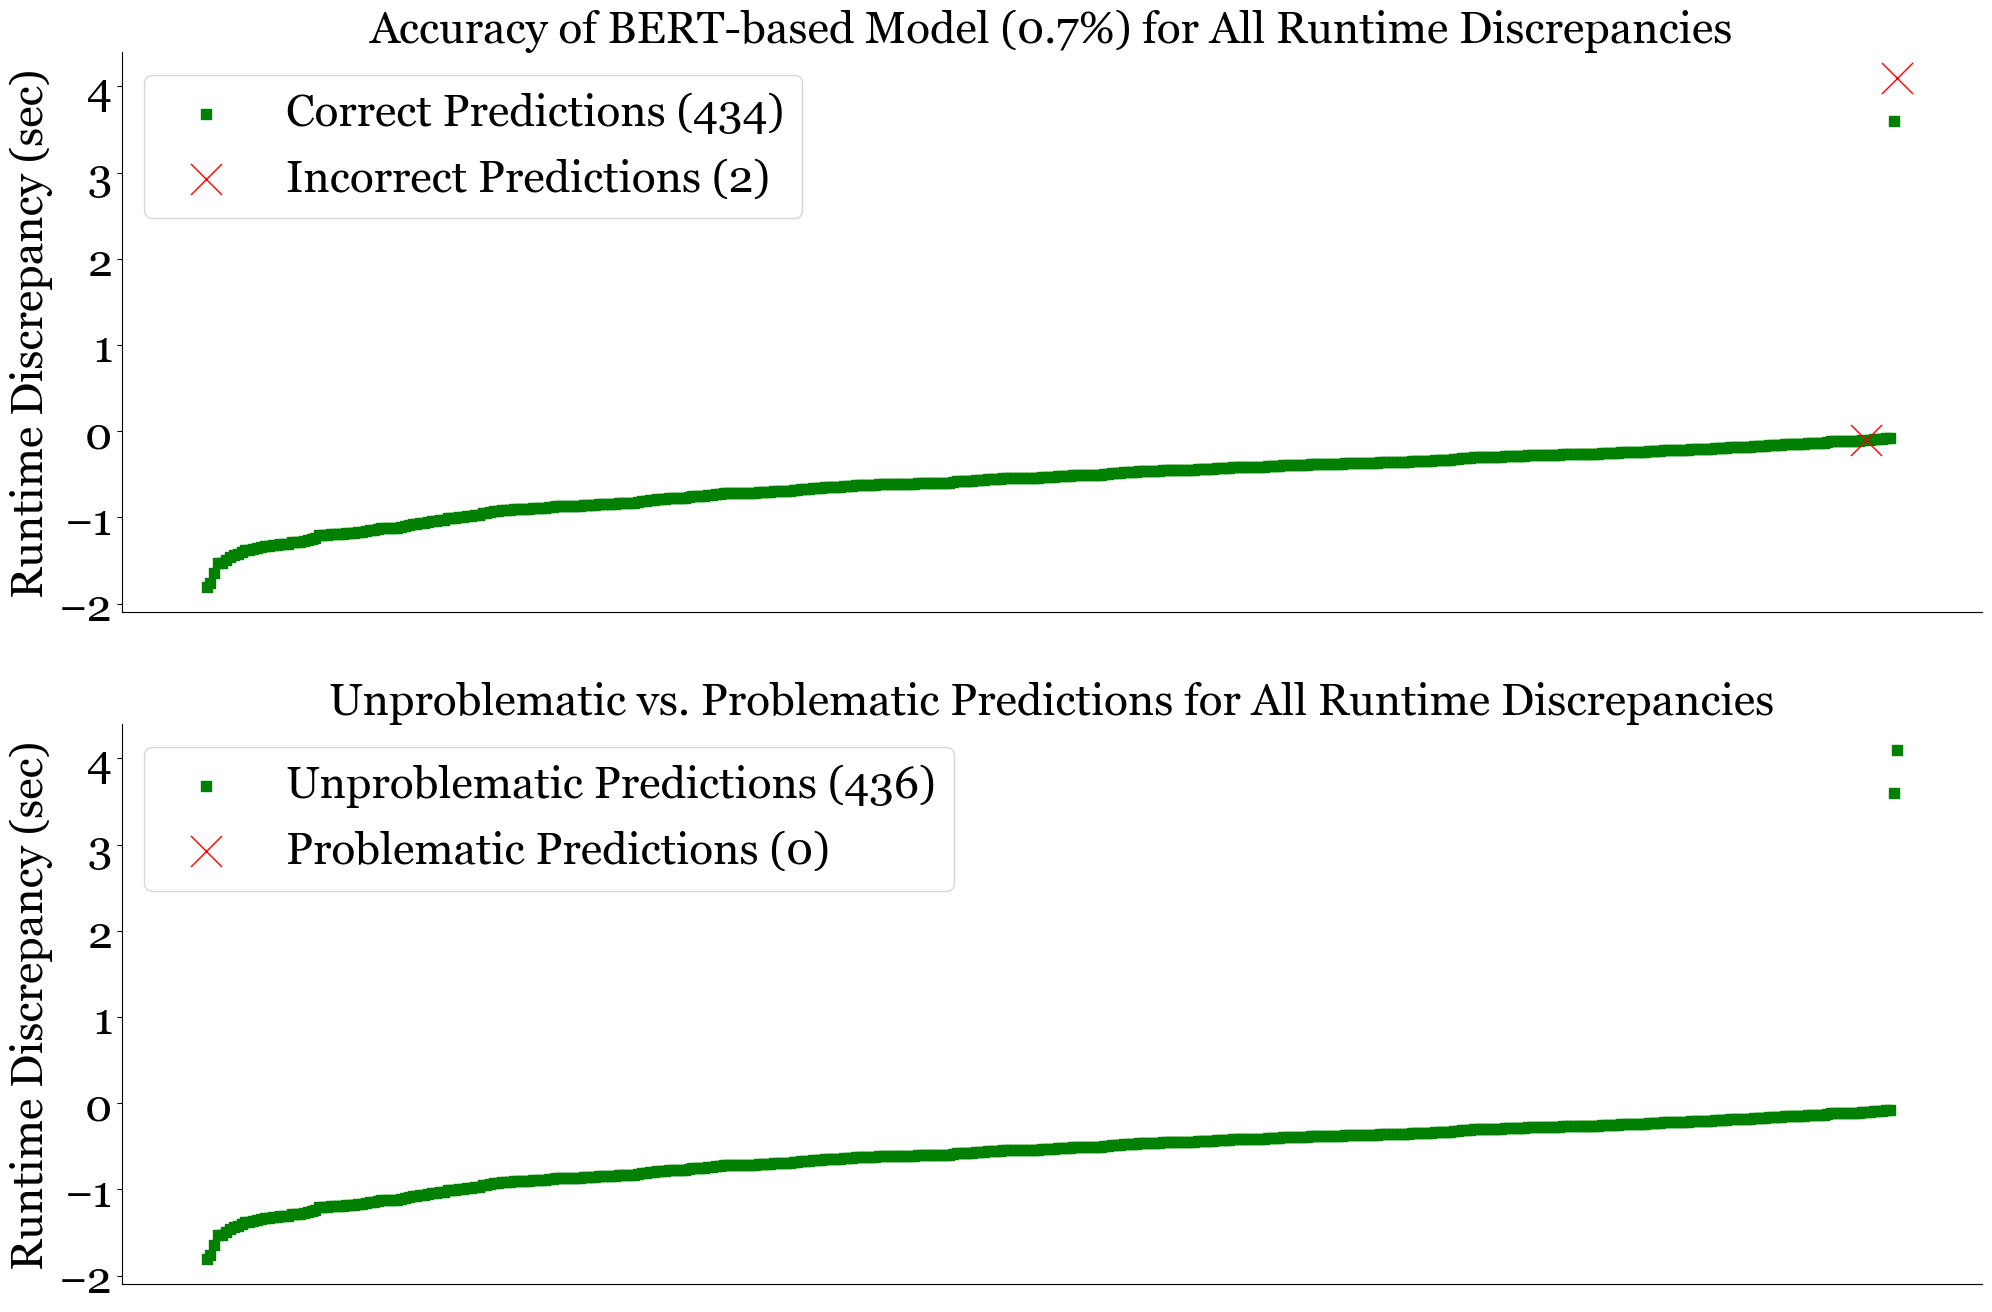

In [45]:
fig, ax = plt.subplots(figsize=(24, 16))

# plot correct and incorrect selections for all time discrepancies
plt.subplot(2, 1, 1)

correct_conditions = (df_test["Correct"] == True)
plt.scatter(
    df_test[correct_conditions].index,
    df_test.loc[correct_conditions, "Time_Discrepancy"], 
    c="g",
    linewidths=1,
    marker="s",
    s=50
)

incorrect_conditions = (df_test["Correct"] == False)
plt.scatter(
    df_test[incorrect_conditions].index,
    df_test.loc[incorrect_conditions, "Time_Discrepancy"], 
    c="r",
    linewidths=1,
    marker="x",
    s=500
)

# set labels
plt.title(
    f"Accuracy of BERT-based Model ({acc:.1f}%) for"
    + " All Runtime Discrepancies", 
    fontsize=32, 
    **gfont
)
plt.ylabel("Runtime Discrepancy (sec)", fontsize=32, **gfont)
plt.legend(
    [f"Correct Predictions ({len(df_test[correct_conditions])})", 
    f"Incorrect Predictions ({len(df_test[incorrect_conditions])})"], 
    prop=font
)

# fix axis
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# plot problematic and nonproblematic selections for all time discrepancies
plt.subplot(2, 1, 2)

nonproblematic_conditions = (
    (df_test["Correct"] == True) \
        | ((df_test["Correct"] == False) \
        & (df_test["Correct_Algorithm_Choice"] == 0)) \
        | ((df_test["Correct"] == False) \
        & (df_test["CutFree_Time"] <= 60))
)
plt.scatter(
    df_test[nonproblematic_conditions].index,
    df_test.loc[nonproblematic_conditions, "Time_Discrepancy"], 
    c="g",
    linewidths=1,
    marker="s",
    s=50
)

# problematic conditions are defined as incorrect predictions that place the 
# system at risk of runtime explosion
problematic_conditions = (
    (df_test["Correct"] == False) \
        & (df_test["Correct_Algorithm_Choice"] == 1) \
        & (df_test["CutFree_Time"] >= 60)
)
plt.scatter(
    df_test[problematic_conditions].index,
    df_test.loc[problematic_conditions, "Time_Discrepancy"], 
    c="r",
    linewidths=1,
    marker="x",
    s=500
)

# set labels
plt.title(
    f"Unproblematic vs. Problematic Predictions for All Runtime"
    + " Discrepancies", 
    fontsize=32, 
    **gfont
)
plt.ylabel(
    "Runtime Discrepancy (sec)", 
    fontsize=32, 
    **gfont
)
plt.legend(
    [f"Unproblematic Predictions ({len(df_test[nonproblematic_conditions])})", 
    f"Problematic Predictions ({len(df_test[problematic_conditions])})"], 
    prop=font
)

# fix axis
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# save figure
plt.savefig(save_folder + "/plots/runtime_discrepancies.png")

In [46]:
# get sensitivity for values above runtime limit
sensitivity = (
    len(df_test[nonproblematic_conditions])) \
        / (len(df_test[nonproblematic_conditions]) \
        + len(df_test[problematic_conditions])
) * 100

# save sensitivity
with open(save_folder + "/results/sensitivity_results.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([sensitivity])
    
sensitivity

100.0

# Load Model and Make New Predictions

In [48]:
# import dependencies
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel, AdamWeightDecay

# load model
best_model = tf.keras.models.load_model(
    save_folder + "/checkpoints/k0_best_model_loss.h5",
    custom_objects={
        "TFDistilBertModel": TFDistilBertModel, 
        "AdamWeightDecay": AdamWeightDecay
    }
)

# load tokenizer
new_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

best_model.evaluate(texts_test, labels_test)

171/171 [==============================] - 16s 86ms/step - loss: 0.6457 - accuracy: 0.8873


[0.6456994414329529, 0.8873239159584045]

In [50]:
# get input
text_1 = "AGCT GGATC GGCC AAGCT CTGCAG GCGGCCGC"
text_2 = "CNNR GGATC GGCC AAGCT CTGCAG GCGGCCGC"
text_attributes = tf.transpose(
    tf.convert_to_tensor(
        ([15, 40, 15, 40])
    )
)

new_tokens_test = new_tokenizer.batch_encode_plus(
    [text_1, text_1, text_2, text_2], 
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

new_input_ids_test = new_tokens_test["input_ids"]
new_attention_mask_test = new_tokens_test["attention_mask"]

new_texts_test = (new_input_ids_test, new_attention_mask_test, text_attributes)

# predict
new_y_pred = np.argmax(best_model.predict(new_texts_test), axis=1)

print(
    "Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL): ", new_y_pred
)

1/1 [==============================] - 2s 2s/step
Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL):  [0 1 0 0]
